# Estimação de dados de obesidade nos *US Counties* utilizando processamento de sinais sobre grafos | *Obesity data estimation in US counties using graph signal processing*

*Dados originais extraídos de (data originally from) https://datausa.io/*

**[PT-BR]** Este notebook contém um exercício de processamento de sinais sobre grafos (GSP, *graph signal processing*) em Python, consistindo da interpolação de dados de obesidade de 2015 nos "condados" americanos (unidades territoriais abaixo
de estado e superior a cidade).

**[EN]** This notebook contains a graph signal processing (GSP) exercise, consisting of the interpolation of 2015 obesity data in US counties. The chosen method was a simple low-pass filtering.

## Leitura dos dados | *Data reading*

**[PT-BR]** A sigla FIPS se refere ao Federal Information Processing Standard
(ou 'padrão federal de processamento de informação') Publication 6-4 (FIPS 6-4),
um código de 5 dígitos que identifica os *counties* americanos. Foram desconsiderados os condados fora da faixa compreendida entre o Canadá e o México.

**[EN]** The FIPS code (Federal Information Processing Standard Publication 6-4) if a 5-digit unique identifier for the US counties. The counties outside the area between Canada and Mexico were discarded.

In [1]:
import pygsp
import pandas as pd
import numpy as np
import networkx as nx
from ex2_utils import nearest_neighbors, describe

pygsp.plotting.BACKEND = 'matplotlib'

df = pd.read_csv('../resources/us_obesity_by_county.csv', sep=',')

# Graph signal: obesity in 2015
s = df['adult_obesity_2015'].to_numpy()

df.head()

,FIPS,Latitude,Longitude,adult_obesity_2015,adult_obesity_2016,adult_obesity_2017
0,1001,32.536382,-86.644490,0.313,0.309,0.341
1,1003,30.659218,-87.746067,0.250,0.267,0.274
2,1005,31.870670,-85.405456,0.384,0.408,0.444
3,1007,33.015893,-87.127148,0.373,0.401,0.403
4,1009,33.977448,-86.567246,0.309,0.324,0.346


## Criando o grafo de kNN | *Creating the kNN graph*

In [2]:
coords = df[['Longitude', 'Latitude']].to_numpy()
N = len(coords)
A_sparse = nearest_neighbors(coords, n_neighbors=4)

print("Description from the graph:")
describe(nx.from_numpy_matrix(A_sparse))

Description from the graph:
n_nodes: 3108
n_edges: 5588
n_self_loops: 0
density: 0.0011573484376831656
is_connected: True
n_connected_components: 1
is_directed: False
is_weighted: True


In [3]:
from pygsp.graphs import Graph

G = Graph(A_sparse, coords=coords, plotting = {
    'vertex_size': 20,
    'vertex_color': (0.12, 0.47, 0.71, 0.8),
    'edge_color': (0.5, 0.5, 0.5, 0.5),
    'edge_width': 1,
})

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Graph(n_vertices=3108, n_edges=9324)'}>)

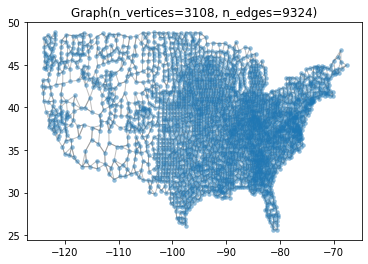

In [4]:
G.plot()

## Dizimando 50% das amostras | *Decimating 50% of samples*

(<Figure size 432x288 with 2 Axes>,
 <AxesSubplot:title={'center':'Graph(n_vertices=3108, n_edges=9324)'}>)

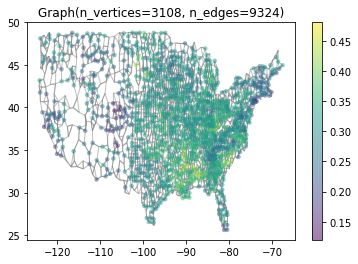

In [5]:
import copy

frac_zero = 0.5
s_ = copy.deepcopy(s)
idx_null = np.random.permutation(len(s))[:int(frac_zero*len(s))]
s_[idx_null] = np.nan
limits = [s.min(), s.max()]

mask_unknown = s_ == 0

G.plot_signal(s_, limits=limits)

## Benchmarking

In [6]:
import numpy as np
from sklearn.impute import KNNImputer
X = [[1, 2, np.nan], [3, 4, 3], [np.nan, 6, 5], [8, 8, 7]]
imputer = KNNImputer(n_neighbors=4)

df_ = df[['Latitude', 'Longitude', 'adult_obesity_2015']].copy()
df_['decimated'] = s_

Ximp = imputer.fit_transform(df_.to_numpy())

(<Figure size 432x288 with 2 Axes>,
 <AxesSubplot:title={'center':'Graph(n_vertices=3108, n_edges=9324)'}>)

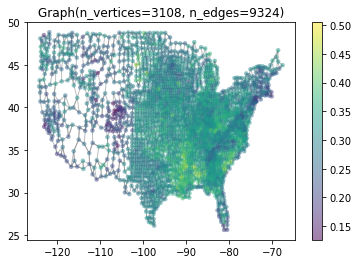

In [27]:
G.plot_signal(s)

## Interpolando | *Interpolation*

In [ ]:
# from pygsp.reduction import interpolate
# from pygsp import graphs

# s_intep = interpolate(
#     G, f_subsampled=s[~bool_is_zero], keep_inds=np.where(~bool_is_zero)[0],
#     order=100, reg_eps=0.005)

# Low-pass filter design

Using least-squares on set of linear equations.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.leastsq.html

In [ ]:
import matplotlib.pyplot as plt

# Matriz Laplaciana
L = np.diag(A.sum(axis=1)) - A

eigvals, U = np.linalg.eig(L)

In [ ]:
import matplotlib.pyplot as plt
# import matplotlib
# matplotlib.rcParams['text.usetex'] = True
# from matplotlib import rc
# # rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# rc('font',**{'serif':['Palatino']})
# # rc('text', usetex=True)

plt.plot(np.sort(eigvals), ':', color='#0022AB', linewidth=2, alpha=1.0)
plt.ylabel(r'Autovalor', fontsize=12)
plt.xlabel(r'Índice do autovalor', fontsize=12)
plt.savefig('laplacian_eig.pdf', dpi=400)
plt.show()

In [ ]:
import numpy as np

deg = 12  # Order of the low-pass filter
eig_vander = np.fliplr(np.vander(eigvals, N=deg+1))

def cost(h_coeff, x_vander, y):
    """
    Cost function for a set of linear equations.

    Parameters
    ----------
    h_coeff : np.ndarray, shape=(L+1,)
        Array of polynomial coefficients.
    x_vander : np.ndarray, shape=(M, L+1)
        Vandermonde matrix with the abscissa.
    y : np.ndarray, shape=(M,)
        Array of expected polynomial outputs.
    """
    assert isinstance(x_vander, np.ndarray), \
        "x must be a np.ndarray."
    return np.abs((x_vander @ h_coeff) - y)

alpha = np.zeros(len(eig_vander))
alpha[:int(len(eig_vander)/4)] = 1

In [ ]:
from scipy.optimize import leastsq

h_coeff_, cov_x, infodict, msg, ier = leastsq(
    cost, x0=np.zeros(deg+1), args=(eig_vander, alpha), full_output=True)

print(f"Optimization output message: {msg}")

In [ ]:
import matplotlib.pyplot as plt
from numpy.polynomial import Polynomial

H = Polynomial(h_coeff_)

import plotly.graph_objects as go
import numpy as np

fig03 = go.Figure(
    data=go.Scatter(
        x=eigvals,
        y=H(eigvals),
        mode='markers',
        marker=dict(
            size=4,
            color="rgba(0, 0, 150, 0.7)")
            )
)

# ---------------------------------------
# Layout adjustments
layout = dict(
    width=700,
    height=400,
    font_size=12,
    paper_bgcolor='rgba(0,0,0,0)',  # Transparent background
    plot_bgcolor='rgba(0,0,0,0)',
    title=dict(
        text='Resposta em frequência do LPF',
        x=0.5,
        xanchor='center',
        yanchor='top'
        ),
    xaxis=dict(
        zerolinecolor="gray",
        ),
    yaxis=dict(
        gridwidth=1,
        gridcolor="gray",
        zeroline=True,
        zerolinewidth=1,
        zerolinecolor="gray",
        )
    )

fig03.update_layout(**layout)

fig03.show(renderer=renderer)
pio.write_image(fig03, 'fig03.pdf', validate=True, engine='kaleido')

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['text.usetex'] = True
from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'serif':['Palatino']})
# rc('text', usetex=True)

plt.plot(eigvals, H(eigvals), 'o', color='#0022AB', markersize=2, alpha=0.7)
plt.xlabel(r'Autovalor', fontsize=14)
plt.ylabel(r'Resposta em frequência', fontsize=14)
plt.savefig('lpf.pdf', dpi=200)
plt.show()

In [ ]:
Ln = nx.normalized_laplacian_matrix(G).toarray()
lpfilter = H(Ln)

In [ ]:
import copy

# Row-normalizing the matrices, i.e. each row is normalized to have unit l1-norm.
# Now the product A_ @ x makes a normalized shift: each vertex receives
# a weighted average of the neighbors; the weights sum up to 1.

A_ = copy.deepcopy(A)
for i, row in enumerate(A_):
    A_[i, :] = row / np.sum(row)

lpfilter_ = copy.deepcopy(lpfilter)
for i, row in enumerate(lpfilter_):
    lpfilter_[i, :] = row / np.sum(row)

In [ ]:
print(f"MSE at non-zero samples of s_: {np.mean((s[~bool_is_zero] - s_[~bool_is_zero])**2)}")
print(f"MSE at zero samples of s_: {np.mean((s[bool_is_zero] - s_[bool_is_zero])**2)}")
print(f"MSE at all samples of s_: {np.mean((s - s_)**2)}")

s_naive = A_ @ s_
s_interp = lpfilter_ @ s_

for i, s_reconstructed in enumerate([s_naive, s_interp]):
    print(f"Case {i+1}:")
    print(f"MSE of s_hat (at originally zero samples): {np.mean((s[bool_is_zero] - s_reconstructed[bool_is_zero])**2)}")

    s_hat = copy.deepcopy(s_)
    s_hat[bool_is_zero] = s_reconstructed[bool_is_zero]

    print(f"MSE of s_hat (at all samples): {np.mean((s - s_hat)**2)}")

## Using PyGSP to interpolate

In [ ]:
from pygsp.reduction import interpolate
from pygsp import graphs

G_pygsp = graphs.Graph(A)

s_intep2 = interpolate(G_pygsp, f_subsampled=s[~bool_is_zero], keep_inds=np.where(~bool_is_zero)[0], order=100, reg_eps=0.005)

In [ ]:
s_reconstructed = s_intep2.ravel()

s_hat = copy.deepcopy(s_)
s_hat[bool_is_zero] = s_reconstructed[bool_is_zero]

print(f"MSE of s_hat (at originally zero samples): {np.mean((s[bool_is_zero] - s_hat[bool_is_zero])**2)}")
print(f"MSE of s_hat (at all samples): {np.mean((s - s_hat)**2)}")